In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import sklearn

# Quiet setting warnings
pd.options.mode.chained_assignment = None

In [51]:
# Set wkdir
WORK_DIR = os.getcwd()

# Import and display data
data = pd.read_csv(f'{WORK_DIR}/brain_stroke.csv')
data.head(5)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


# Some Functions

In [62]:
def X_y_split(df, target, to_numpy: bool):
    '''
    Function to split df into features (X) and target (y)
    to_numpy boolean flag can be used to convert X and y outputs to numpy arrays
    '''
    X = df.loc[:, df.columns != target]
    y = df.loc[:, target]
    if to_numpy:
        return X.to_numpy(), y.to_numpy()
    else:
        return X, y
    

def numFeature_distribution(df, n_col, bins, fig_width, fig_height, hspace, wspace):
    '''
    Function to plot the distribution of each numeric feature in a data frame
    '''

    # Extract features to plot - only numeric features will work here
    numeric_features = list(df.select_dtypes(include=[np.number]).columns)
    
    # Set figure space
    plt.style.use('seaborn')
    n_row = int(np.ceil(len(numeric_features)/n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(fig_width, fig_height), 
                            gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)

    # Plot distributions and test for normality
    for i, feature in enumerate(numeric_features):
        
        # Plot
        sns.histplot(data=df, x=feature, ax=plots[i], color='tab:blue', bins=bins)
        plots[i].set_title(feature, fontsize=12)
        plots[i].set_xlabel('')
        
    plt.show()
        

def catFeature_balance(df, n_col, fig_width, fig_height, hspace, wspace):
    '''
    Function to plot the distribution of each categorical feature in a data frame
    '''
    
    # Set figure space
    plt.style.use('seaborn')
    catFeatures = df.columns
    n_row = int(np.ceil(len(catFeatures)/n_col))
    fig, axs = plt.subplots(n_row, n_col, figsize=(fig_width, fig_height), 
                            gridspec_kw={"hspace": hspace, "wspace": wspace})
    plots = []
    for ax in axs:
        try:
            for plot in ax:
                plots.append(plot)
        except:
            plots.append(ax)

    # Plot distributions and test for normality
    for i, feature in enumerate(catFeatures):
        
        # Set count df for plot
        labels = [str(label) for label in list(set(df[feature]))]
        counts = [list(df[feature]).count(c) for c in labels]
        plot_df = pd.DataFrame({'labels': [label if label is not np.nan else "Missing" for label in labels], 
                                'counts': counts})
        
        # Plot
        sns.barplot(data=plot_df, y="labels", x="counts", ax=plots[i], color="tab:blue")
        plots[i].set_title(feature, fontsize=12)
        plots[i].set_ylabel('')
        
    plt.show()
    
    

# EDA
## Missing Data

In [7]:
# View missing data for 50 sample set - no missing data
print('Missing Data:')
print(data.isnull().sum())

Missing Data:
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


## Visualizing Target & Feature Balance/Distributions

In [25]:
# Split into target/features
X, y = X_y_split(data, target='stroke', to_numpy=False)

# Split features in numeric/categorical sets
numFeatures = ['age', 'avg_glucose_level', 'bmi']
catFeatures = [feat for feat in X.columns if feat not in numFeatures]
X_numDF = X[numFeatures]
X_catDF = X[catFeatures]

### Numeric Features

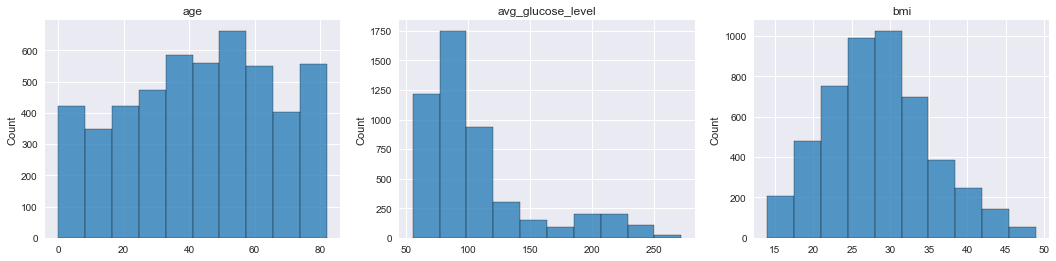

In [31]:
# Plot distributions
numFeature_distribution(df=X_numDF, n_col=3, fig_width=18, fig_height=4, bins=10, hspace=0.3, wspace=0.2)

### Categorical Features

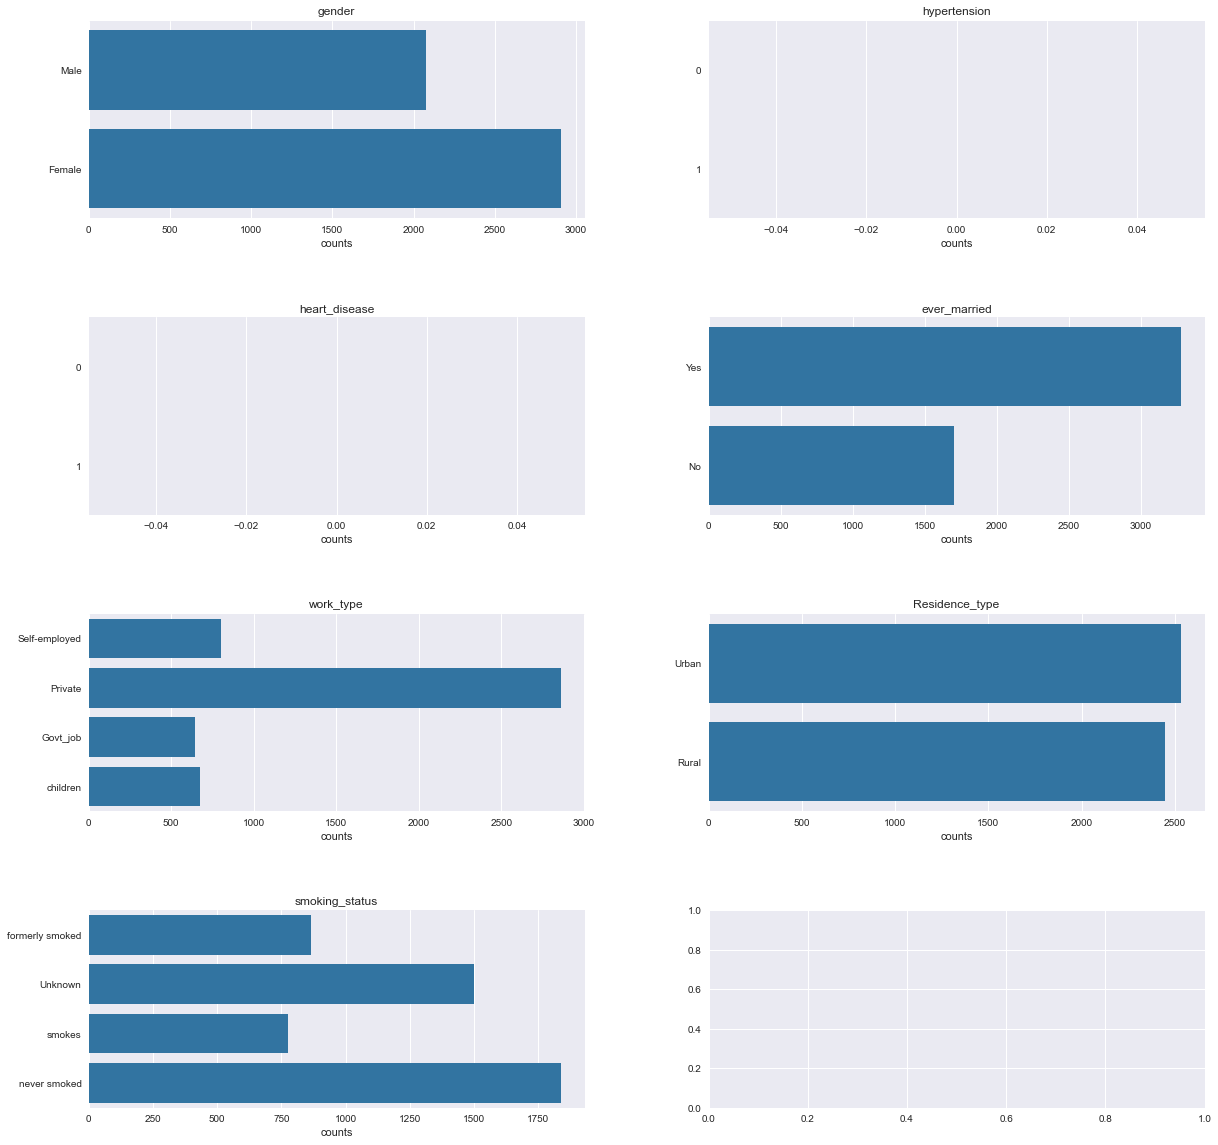

In [63]:
# Convert binary variables to categorical for plot
X_catDF['hypertension'] = X_catDF['hypertension'].astype('object')
X_catDF['heart_disease'] = X_catDF['heart_disease'].astype('object')
X_catDF.dtypes

# Plot class balances
catFeature_balance(df=X_catDF, n_col=2, fig_width=20, fig_height=20, hspace=0.5, wspace=0.25)

In [42]:
len(X_catDF.columns)

7